In [1]:
from collections import defaultdict
from dataclasses import dataclass
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns

In [2]:
@dataclass
class SCIMVisConfig:
    n_nodes: int
    n_factories: int
    n_stores: int
    dataset: str
    epi_len: int = 30


configs = {
    "1f2s": SCIMVisConfig(n_nodes=3, n_factories=1, n_stores=2, dataset="1F2S"),
    "1f3s": SCIMVisConfig(n_nodes=4, n_factories=1, n_stores=3, dataset="1F3S"),
    "1f10s": SCIMVisConfig(n_nodes=11, n_factories=1, n_stores=10, dataset="1F10S"),
}


def get_config(dataset: str) -> SCIMVisConfig:
    return configs[dataset]


scenario = "scim"
algos = ["dmfc", "grl"]
algo_labels = ["DMFC(Ours)", "GraphRL"]

# preface_color = "#f3f0e1"
dmfc_color = "#c33b75"
grl_color1 = "#4ba0ec"
grl_color2 = "#fac17b"
gray_color = "#bbbebd"

red_color = "#be2727"
blue_color = "#0040ff"
# gray_color = "#808080"
line_width = 1.5

dpi = 600  # image dpi
labelsize = 18
ticksize = 15
legendsize = 12
alpha = 0.8

result_path = Path().cwd() / "results" / scenario
datasets = {f.name: f for f in result_path.iterdir() if f.is_dir()}
algos = ["dmfc", "grl"]
datasets_name = ["1f2s", "1f3s", "1f10s"]

plot_params = {
    "dmfc": {
        "color": dmfc_color,
        "linestyle": "-",
        "marker": "o",
        "label": "DMFC(Ours)",
    },
    "grl": {
        "color": grl_color1,
        "linestyle": "--",
        "marker": "^",
        "label": "GraphRL",
    },
}

# Load Data

In [3]:
demand_data = defaultdict(dict)
prod_data = defaultdict(dict)
waiting_data = defaultdict(dict)
overstock_data = defaultdict(dict)
stock_data = defaultdict(dict)
storage_cost = defaultdict(dict)
trans_cost = defaultdict(dict)

# datasets
for idx, (dataset, path) in enumerate(datasets.items()):
    for algo in algos:
        path = result_path / dataset / algo / "cosine"

        with open(path / "demands.csv", "r") as f:
            demand = pd.read_csv(f, header=None)
        demand = demand.to_numpy().mean(axis=0).reshape(30, -1).sum(axis=1)
        demand_data[dataset][algo] = demand

        with open(path / "prods.csv", "r") as f:
            prod = pd.read_csv(f, header=None)
        prod = prod.mean(axis=0).to_numpy()
        prod_data[dataset][algo] = prod

        with open(path / "waitings.csv", "r") as f:
            waitings = pd.read_csv(f, header=None)
        waitings = waitings.mean(axis=0).to_numpy()
        waiting_data[dataset][algo] = waitings

        with open(path / "overstocks.csv", "r") as f:
            overstocks = pd.read_csv(f, header=None)
        overstocks = overstocks.mean(axis=0).to_numpy()
        overstock_data[dataset][algo] = overstocks

        with open(path / "stocks.csv", "r") as f:
            stocks = pd.read_csv(f, header=None)
        stocks = stocks.to_numpy().mean(axis=0).reshape(30, -1).sum(axis=1)
        stock_data[dataset][algo] = stocks

        with open(path / "storage_cost.csv", "r") as f:
            costs = pd.read_csv(f, header=None)
        costs = costs.mean(axis=0).to_numpy()
        storage_cost[dataset][algo] = costs

        with open(path / "trans_cost.csv", "r") as f:
            costs = pd.read_csv(f, header=None)
        costs = costs.mean(axis=0).to_numpy()
        trans_cost[dataset][algo] = costs

In [4]:
for dataset in datasets:
    for algo in algos:
        demand = demand_data[dataset][algo].sum()
        stocks = stock_data[dataset][algo].sum()
        overstocks = overstock_data[dataset][algo].sum()
        waitings = waiting_data[dataset][algo].sum()
        prod = prod_data[dataset][algo].sum()
        s_cost = storage_cost[dataset][algo].sum()
        t_cost = trans_cost[dataset][algo].sum()
        desc = {
            f"{dataset}_{algo}, "
            f"demand = {int(demand)}, "
            f"stock = {int(stocks)}, "
            f"storage_cost = {int(s_cost)}, "
            f"trans_cost = {int(t_cost)}, "
            f"overstock = {int(overstocks)}, "
            f"waitings = {int(waitings)}, "
            f"prod = {int(prod)}, "
        }
        print(desc)

{'1f3s_dmfc, demand = 510, stock = 494, storage_cost = 676, trans_cost = 162, overstock = 4, waitings = 98, prod = 565, '}
{'1f3s_grl, demand = 510, stock = 927, storage_cost = 1227, trans_cost = 165, overstock = 0, waitings = 110, prod = 580, '}
{'1f10s_dmfc, demand = 1689, stock = 1476, storage_cost = 2278, trans_cost = 531, overstock = 3, waitings = 395, prod = 1852, '}
{'1f10s_grl, demand = 1689, stock = 3084, storage_cost = 5080, trans_cost = 543, overstock = 0, waitings = 396, prod = 1911, '}
{'1f2s_dmfc, demand = 326, stock = 366, storage_cost = 766, trans_cost = 188, overstock = 4, waitings = 71, prod = 361, '}
{'1f2s_grl, demand = 327, stock = 490, storage_cost = 1113, trans_cost = 186, overstock = 0, waitings = 68, prod = 363, '}


/tmp/ipykernel_3829029/2668390557.py:52: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(right=0.75)


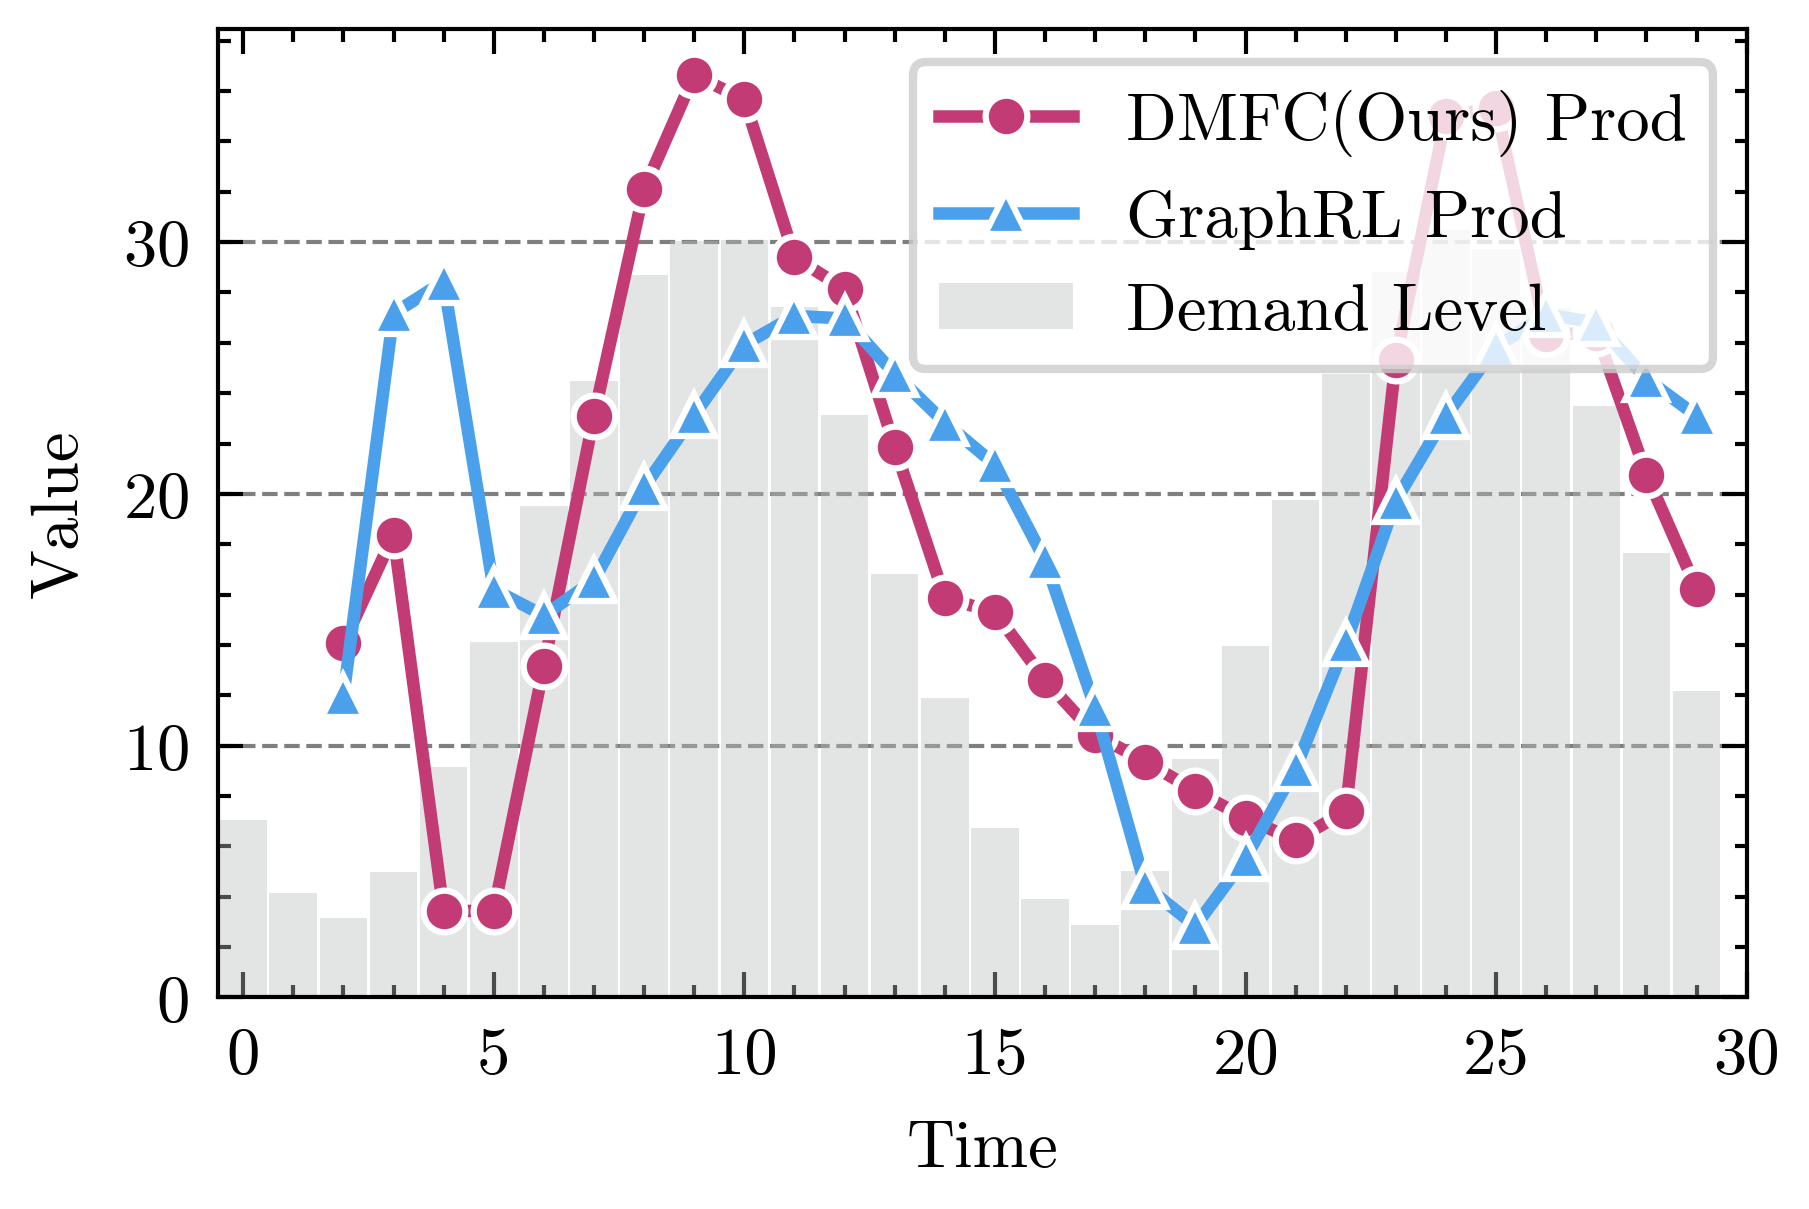

In [5]:
sns.set_style()
plt.style.use(["science", "ieee", "no-latex", "grid"])
fig, axes = plt.subplots(1, 1, dpi=dpi, figsize=(3, 2), constrained_layout=True)


demand = demand_data["1f3s"]["dmfc"]

for algo in algos:
    data = prod_data["1f3s"][algo]
    x = np.arange(len(data))[2:]
    y = data[:-2]

    sns.lineplot(
        x=x,
        y=y,
        ax=axes,
        label=f"{plot_params[algo]['label']} Prod",
        color=plot_params[algo]["color"],
        linewidth=1.5,
        markers=True,
        marker=plot_params[algo]["marker"],
        markersize=5,
    )

df_demand = pd.DataFrame({"time": np.arange(len(demand)), "value": demand})
sns.barplot(
    x="time",
    y="value",
    data=df_demand,
    ax=axes,
    color=gray_color,
    alpha=0.4,
    width=0.95,
    label="Demand Level",
)

axes.set_xticks(np.arange(0, 31, 5))
axes.set_xticklabels(np.arange(0, 31, 5))


axes.set_xlabel("Time")
axes.set_ylabel("Value")
axes.legend(framealpha=alpha)

# axes.set_xlabel("Time (step)", fontsize=labelsize)
# axes.set_ylabel("Number", fontsize=labelsize)
# axes.tick_params(labelsize=ticksize, axis="both")
# axes.legend(
#     fontsize=legendsize, framealpha=alpha, loc="center left", bbox_to_anchor=(1, 0.5)
# )

fig.subplots_adjust(right=0.75)
fig.savefig(result_path / "1f3s.pdf", dpi=dpi)